In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats

df = pd.read_csv("../data/final/healthcare_efficiency_master.csv")

spending_categories = ['hospitals', 'physicians', 'drugs', 'administration', 'other_professionals', 'public_health']

# Calculate correlations with wait times
correlations = []
for category in spending_categories:
    corr, p_value = stats.pearsonr(df[category], df['avg_wait_time'])
    correlations.append({
        'Spending_Category': category,
        'Correlation_with_Wait_Time': corr,
        'P_Value': p_value,
        'Significant': p_value < 0.05
    })

correlation_table = pd.DataFrame(correlations).round(3)
correlation_table = correlation_table.sort_values('Correlation_with_Wait_Time', key=abs, ascending=False)

print("Correlation Analysis - Spending vs Wait Times:")
print(correlation_table.to_string(index=False))

Correlation Analysis - Spending vs Wait Times:
  Spending_Category  Correlation_with_Wait_Time  P_Value  Significant
     administration                       0.315    0.000         True
          hospitals                       0.230    0.003         True
      public_health                       0.131    0.089        False
              drugs                       0.128    0.098        False
         physicians                      -0.094    0.226        False
other_professionals                      -0.070    0.365        False


In [2]:
X = df[spending_categories].copy()
y = df['avg_wait_time'].copy()

# Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Model
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Linear Regression Model Performance:")
performance_df = pd.DataFrame({
    'Metric': ['Training R²', 'Testing R²', 'Mean Absolute Error (days)'],
    'Value': [train_r2, test_r2, test_mae]
}).round(3)
print(performance_df.to_string(index=False))

# Regression coefficients (impact per $1 spending change)
coefficients = pd.DataFrame({
    'Spending_Category': spending_categories,
    'Coefficient': lr_model.coef_,
    'Impact_per_100_dollars': lr_model.coef_ * 100
}).round(4)

coefficients = coefficients.sort_values('Coefficient')
print(f"\nRegression Coefficients (days change per $1 spending):")
print(coefficients.to_string(index=False))

Linear Regression Model Performance:
                    Metric  Value
               Training R²  0.381
                Testing R²  0.213
Mean Absolute Error (days) 12.306

Regression Coefficients (days change per $1 spending):
  Spending_Category  Coefficient  Impact_per_100_dollars
         physicians      -0.1136                -11.3579
other_professionals       0.0080                  0.7997
          hospitals       0.0086                  0.8592
              drugs       0.0358                  3.5762
      public_health       0.0545                  5.4516
     administration       0.1423                 14.2281


In [3]:
avg_spending = df[spending_categories].mean()

print("Budget Reallocation Impact Analysis:")
print(f"Average spending per capita:")
avg_spending_df = pd.DataFrame({
    'Category': spending_categories,
    'Average_Spending': avg_spending.values
}).round(0)
print(avg_spending_df.to_string(index=False))

# Calculate impact of $100 reallocation between categories
reallocation_impact = []
for from_category in spending_categories:
    for to_category in spending_categories:
        if from_category != to_category:
            from_coef = coefficients[coefficients['Spending_Category'] == from_category]['Coefficient'].iloc[0]
            to_coef = coefficients[coefficients['Spending_Category'] == to_category]['Coefficient'].iloc[0]
            
            # Impact of moving $100 from one category to another
            net_impact = (to_coef - from_coef) * 100
            
            reallocation_impact.append({
                'From_Category': from_category,
                'To_Category': to_category,
                'Wait_Time_Change_Days': net_impact
            })

reallocation_df = pd.DataFrame(reallocation_impact).round(2)
reallocation_df = reallocation_df.sort_values('Wait_Time_Change_Days')

# # Getting top 5 and bottom 5
# print(f"\nTop 5 Most Beneficial $100 Reallocations:")
# top_reallocations = reallocation_df.head(5)
# print(top_reallocations.to_string(index=False))

# print(f"\nTop 5 Most Harmful $100 Reallocations:")
# worst_reallocations = reallocation_df.tail(5)
# print(worst_reallocations.to_string(index=False))

Budget Reallocation Impact Analysis:
Average spending per capita:
           Category  Average_Spending
          hospitals            2057.0
         physicians             949.0
              drugs            1010.0
     administration             221.0
other_professionals             654.0
      public_health             384.0


In [4]:
# Realistic policy scenarios based on current averages
baseline_spending = avg_spending.copy()
baseline_prediction = lr_model.predict([baseline_spending])[0]

# Some scenarios of What If we increase this resource, how would this change things?
# Reduce admin by 20%, increase hospitals by 15%, physicians by 5%
scenario_1 = baseline_spending.copy()
admin_reduction = baseline_spending['administration'] * 0.2
scenario_1['administration'] -= admin_reduction
scenario_1['hospitals'] += admin_reduction * 0.75  # 75% to hospitals
scenario_1['physicians'] += admin_reduction * 0.25  # 25% to physicians
scenario_1_pred = lr_model.predict([scenario_1])[0]

# Increase physicians by 25%, funded by reducing other categories proportionally
scenario_2 = baseline_spending.copy()
physician_increase = baseline_spending['physicians'] * 0.25
other_categories = [c for c in spending_categories if c != 'physicians']
reduction_per_category = physician_increase / len(other_categories)
scenario_2['physicians'] += physician_increase
for category in other_categories:
    scenario_2[category] -= reduction_per_category
scenario_2_pred = lr_model.predict([scenario_2])[0]

# Balanced clinical focus - reduce admin and other, increase hospitals and physicians
scenario_3 = baseline_spending.copy()
total_reduction = baseline_spending['administration'] * 0.15 + baseline_spending['other_professionals'] * 0.1
scenario_3['administration'] -= baseline_spending['administration'] * 0.15
scenario_3['other_professionals'] -= baseline_spending['other_professionals'] * 0.1
scenario_3['hospitals'] += total_reduction * 0.6
scenario_3['physicians'] += total_reduction * 0.4
scenario_3_pred = lr_model.predict([scenario_3])[0]

# Scenario resultsa
scenarios_df = pd.DataFrame({
    'Scenario': [
        'Current Average',
        'Admin to Clinical Shift',
        'Physician Investment Focus', 
        'Balanced Clinical Focus'
    ],
    'Predicted_Wait_Time': [baseline_prediction, scenario_1_pred, scenario_2_pred, scenario_3_pred],
    'Change_from_Current': [0, scenario_1_pred - baseline_prediction, 
                           scenario_2_pred - baseline_prediction, scenario_3_pred - baseline_prediction]
}).round(1)

print("Realistic Policy Scenarios (Budget-Neutral):")
print(scenarios_df.to_string(index=False))

Realistic Policy Scenarios (Budget-Neutral):
                  Scenario  Predicted_Wait_Time  Change_from_Current
           Current Average                 61.3                  0.0
   Admin to Clinical Shift                 54.0                 -7.3
Physician Investment Focus                 22.5                -38.8
   Balanced Clinical Focus                 52.0                 -9.2


/Users/thedarianwong/Downloads/CMPT 353/Data Science/Project/healthcare-efficiency-canada/healthcare_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/thedarianwong/Downloads/CMPT 353/Data Science/Project/healthcare-efficiency-canada/healthcare_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/thedarianwong/Downloads/CMPT 353/Data Science/Project/healthcare-efficiency-canada/healthcare_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/thedarianwong/Downloads/CMPT 353/Data Science/Project/healthcare-efficiency-canada/healthcare_venv/lib/python3.13/site-packages/skle

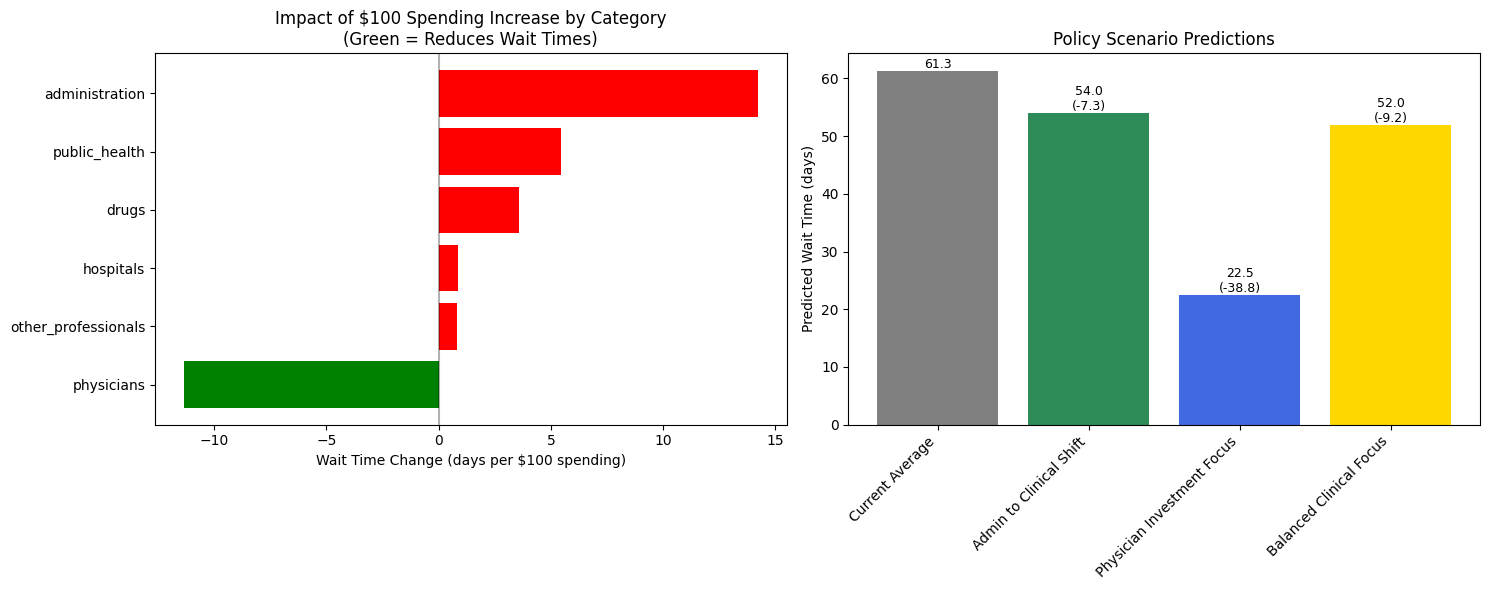

In [5]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Regression Coefficients
colors = ['red' if coef > 0 else 'green' for coef in coefficients['Coefficient']]
bars1 = ax1.barh(coefficients['Spending_Category'], coefficients['Impact_per_100_dollars'], color=colors)
ax1.set_xlabel('Wait Time Change (days per $100 spending)')
ax1.set_title('Impact of $100 Spending Increase by Category\n(Green = Reduces Wait Times)')
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Chart 2: Policy Scenarios
scenario_colors = ['gray', '#2E8B57', '#4169E1', '#FFD700']
bars2 = ax2.bar(range(len(scenarios_df)), scenarios_df['Predicted_Wait_Time'], color=scenario_colors)
ax2.set_xticks(range(len(scenarios_df)))
ax2.set_xticklabels(scenarios_df['Scenario'], rotation=45, ha='right')
ax2.set_ylabel('Predicted Wait Time (days)')
ax2.set_title('Policy Scenario Predictions')

for i, bar in enumerate(bars2):
    height = bar.get_height()
    change = scenarios_df.iloc[i]['Change_from_Current']
    label = f'{height:.1f}\n({change:+.1f})' if change != 0 else f'{height:.1f}'
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()